<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Found existing installation: wavefilter 0.0.1
Uninstalling wavefilter-0.0.1:
  Successfully uninstalled wavefilter-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-3558dn5k/wavefilter_1b84d1f7c95f40439c4c3e741377b647
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-3558dn5k/wavefilter_1b84d1f7c95f40439c4c3e741377b647
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=8580 sha256=cb80dc26683e2eaf21e7d278def89e1a47cdd2e16bef02cacf4070b393bfcb4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_s5b07zw/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder, CaptureActivations
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import inspect
lines = inspect.getsource(models.Conv1dPulseFinderAttentionBase.forward_step1)
print(lines)

    def forward_step1(self, ampl: torch.Tensor, original: torch.Tensor) -> Any:
        # Should be returning `torch.Tensor`:
        pf = self.pulse_finder(original)
        inputs: Tuple[torch.Tensor, ...] = (original, pf)
        if self.use_amplitude:
            inputs += (ampl,)
        concat = torch.concat(inputs, dim=-2)
        return self.combine(concat)



## Make some data

In [4]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[-1.4456457 , -4.6974797 , -2.3192537 , ...,  0.12918131,
         0.5033101 ,  3.2589972 ],
       [-1.18517   ,  1.920035  ,  0.53152573, ..., -2.151908  ,
        -0.9500445 , -0.703467  ],
       [ 0.3287248 , -1.0145366 ,  1.1418011 , ..., -2.1458724 ,
        -3.1986609 , -0.8219376 ],
       ...,
       [-1.9068822 , -3.0441136 , -0.9655843 , ...,  8.178115  ,
         6.822249  ,  2.6401844 ],
       [ 0.88566184, -1.3192062 , -0.6008783 , ...,  0.73685825,
         3.5985513 ,  3.0047271 ],
       [ 0.36887223, -0.25802407, -1.8534157 , ..., -2.9025564 ,
        -1.8150926 , -3.2365742 ]], dtype=float32)

In [5]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f5d8426f6b0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f5cf6a9f110>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f5cf6aa2110>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f5cf6aa4110>)]


## Set up the model

In [25]:
class Conv1dPulseFinderAttention_v4(models.Conv1dPulseFinderAttentionBase):
    def forward(self, ampl: torch.Tensor, original: torch.Tensor):
        inputs = super().forward_step1(ampl, original)
        scale = self.scale(inputs)
        attend = torch.tanh(F.softshrink(scale))
        return F.softmax(attend, -1)

attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention_v4(100, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention_v4(
      (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [26]:
params = split_parameters(model, ['attend'])

In [27]:
lr_schedules = [lambda x: 0.95**x, lambda x: 0.99]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params, lr_schedules=lr_schedules, device=device, epochs=300)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Inspect what we've learnt

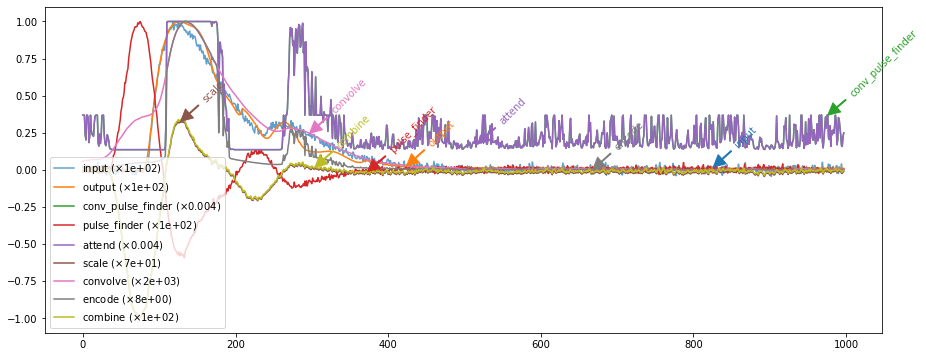

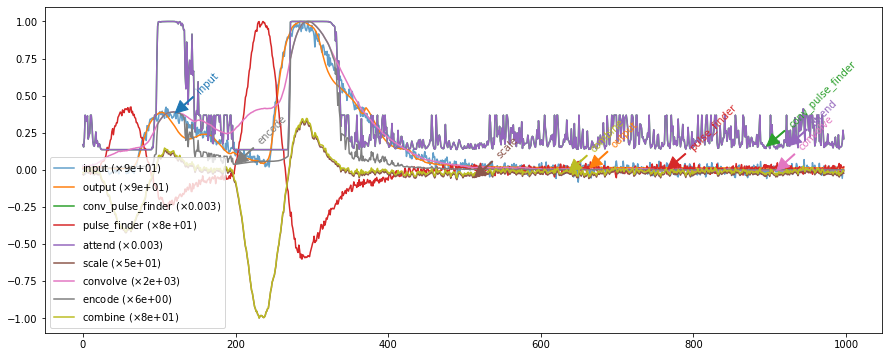

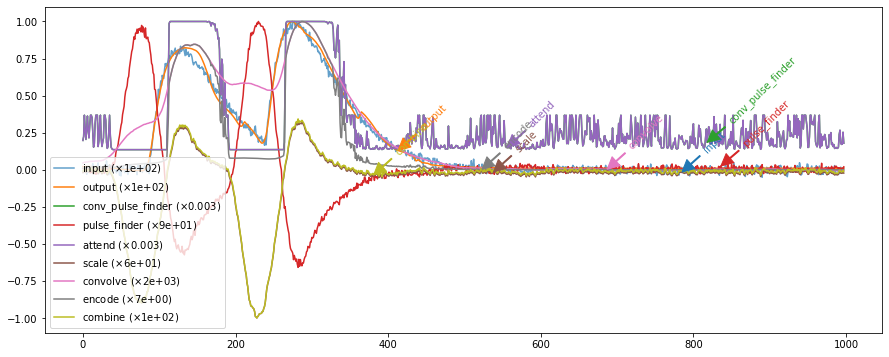

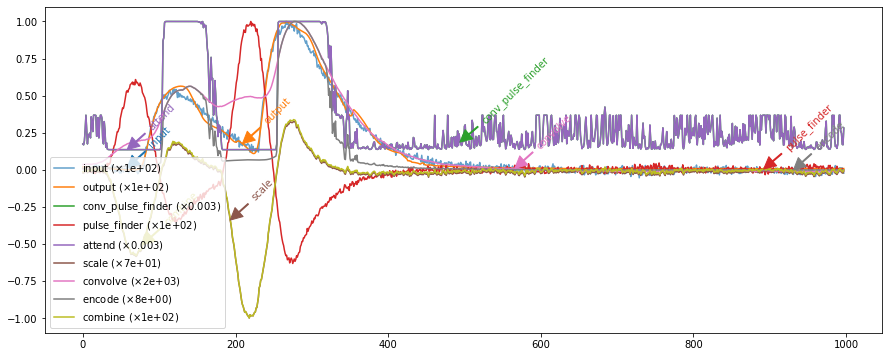

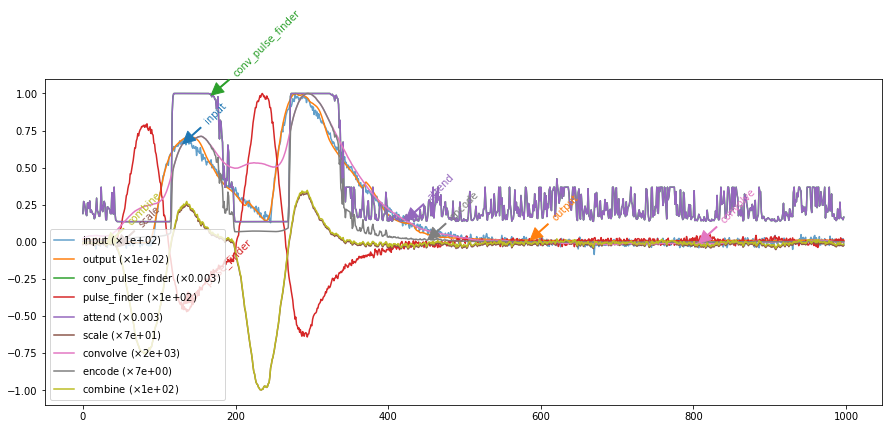

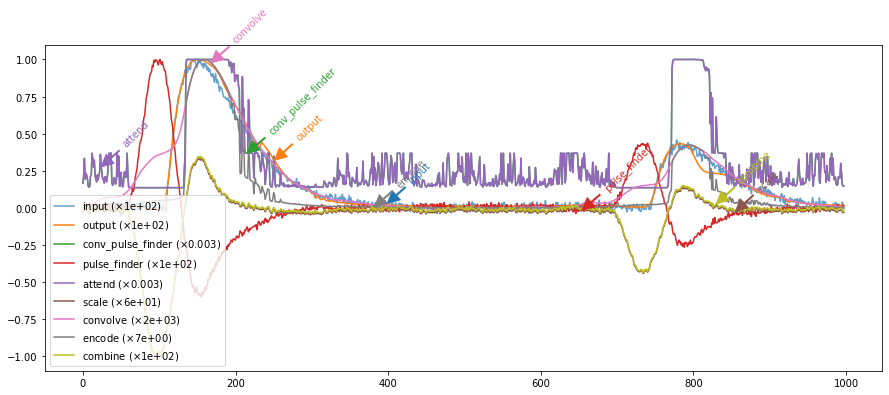

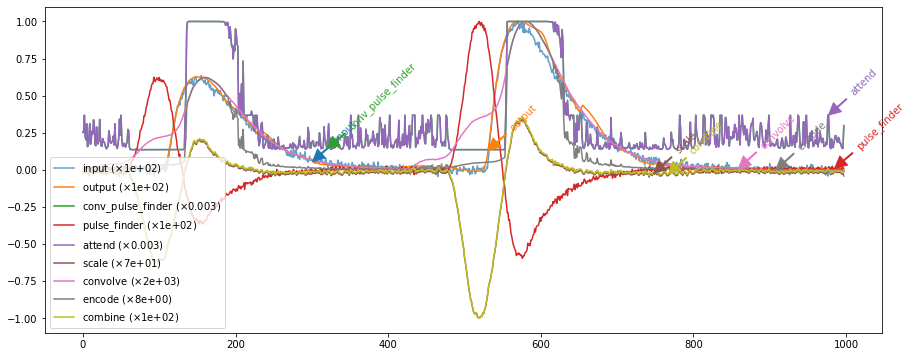

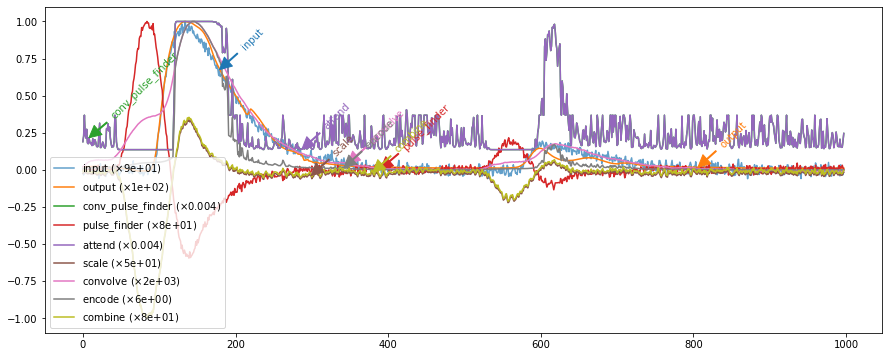

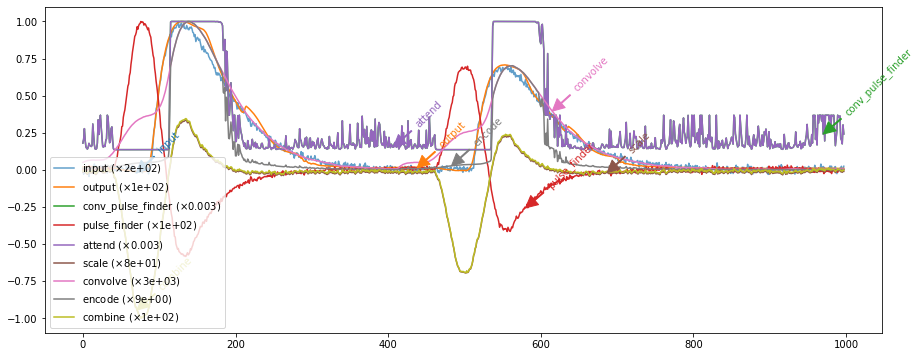

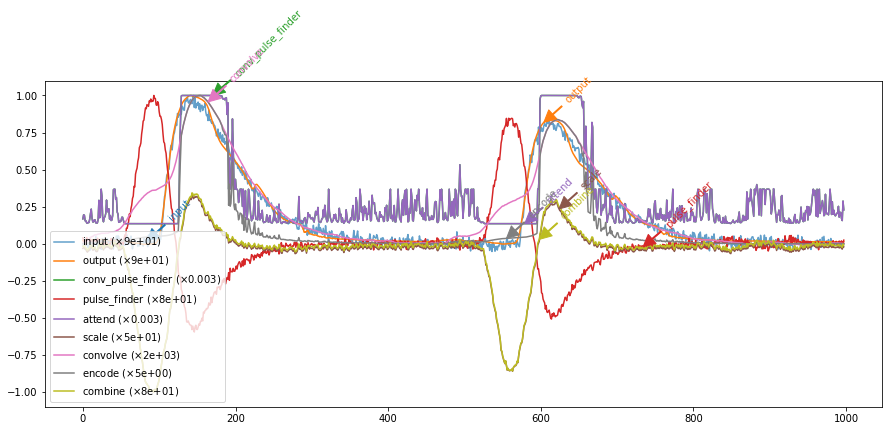

In [28]:
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['conv_pulse_finder', 'pulse_finder', 'attend', 'scale', 'convolve' , 'encode', 'combine']:
  #for i in ['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

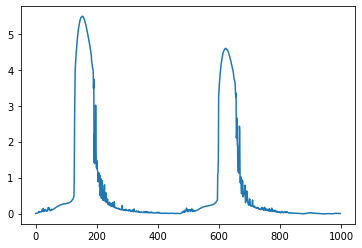

In [29]:
plt.plot(activations["encode"][0].cpu().numpy())

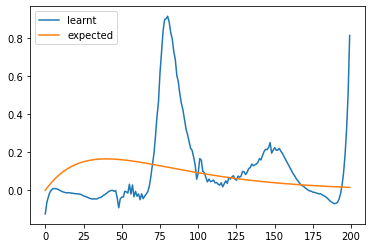

In [30]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

0.03126684

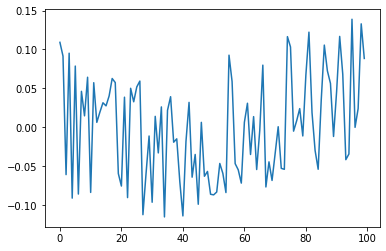

In [31]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

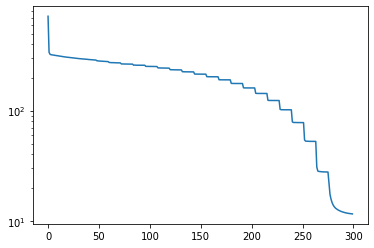

In [32]:
plt.plot(tester.train_loss);
plt.yscale("log")

In [33]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[-1.2389e-01, -6.4426e-02, -3.5000e-02, -1.0262e-02,  1.7495e-03,
           8.5898e-03,  9.0544e-03,  8.6379e-03,  6.1002e-03,  1.9788e-03,
          -2.4906e-03, -6.5496e-03, -9.4249e-03, -1.1673e-02, -1.3807e-02,
          -1.2310e-02, -1.2890e-02, -1.5058e-02, -1.5359e-02, -1.7301e-02,
          -1.7786e-02, -1.8649e-02, -1.9512e-02, -2.1074e-02, -2.4625e-02,
          -2.9377e-02, -3.1764e-02, -3.4817e-02, -3.8245e-02, -4.2588e-02,
          -4.4006e-02, -4.6081e-02, -4.4412e-02, -4.5616e-02, -4.4802e-02,
          -3.9260e-02, -3.7913e-02, -3.3829e-02, -2.6535e-02, -2.2105e-02,
          -1.6443e-02, -9.1990e-03, -4.5768e-03, -8.0628e-04, -2.4236e-04,
          -5.2278e-03, -1.5209e-03, -3.9067e-02, -9.1889e-02, -4.5170e-02,
          -3.5631e-02, -3.5772e-02, -5.0524e-03, -7.9980e-03, -1.4627e-02,
           3.1743e-02, -1.9558e-02,  2.7862e-02, -3.4140e-02, -5.5206e-03,
          -3.0928e-02, -1.9274e-02, -4.9200e-02, -1.8430e-02